In [24]:
def getNxt(p):
    n = len(p)
    nxt = [0]*n

    for i in range(n):
        for k in range(i,0,-1):
            if p[:k] == p[i-k+1:i+1]:
                nxt[i] = k
                break
    return nxt

def search(s,p):
    n = len(s) #主串长度
    m = len(p) #模式串长度

    nxt = getNxt(p)

    i = 0 #主串指针
    j = 0 #模式串指针

    while i <n :
        if s[i] == p[j]:#当前字符匹配
            i += 1
            j += 1
            if j == m: #模式串匹配完成
                return i - j#找到匹配，返回起始位置
                #  j =nxt[j-1]
        else: #不匹配
            if j > 0 : #j不是0才可以回退
                j = nxt[j-1] #模式指针跳回到nxt[j - 1]
            
            else: i +=1
    return -1 #没找到

### kmp算法

kmp算法事一种**字符串匹配**suanfa ,可以在$O(n+m)$的时间复杂度内实现两个字符串的匹配。

[参考知乎文章](https://www.zhihu.com/question/21923021)

#### 字符串匹配问题

字符串P是否为字符串S的子串？如果是，他出现在S的哪些位置

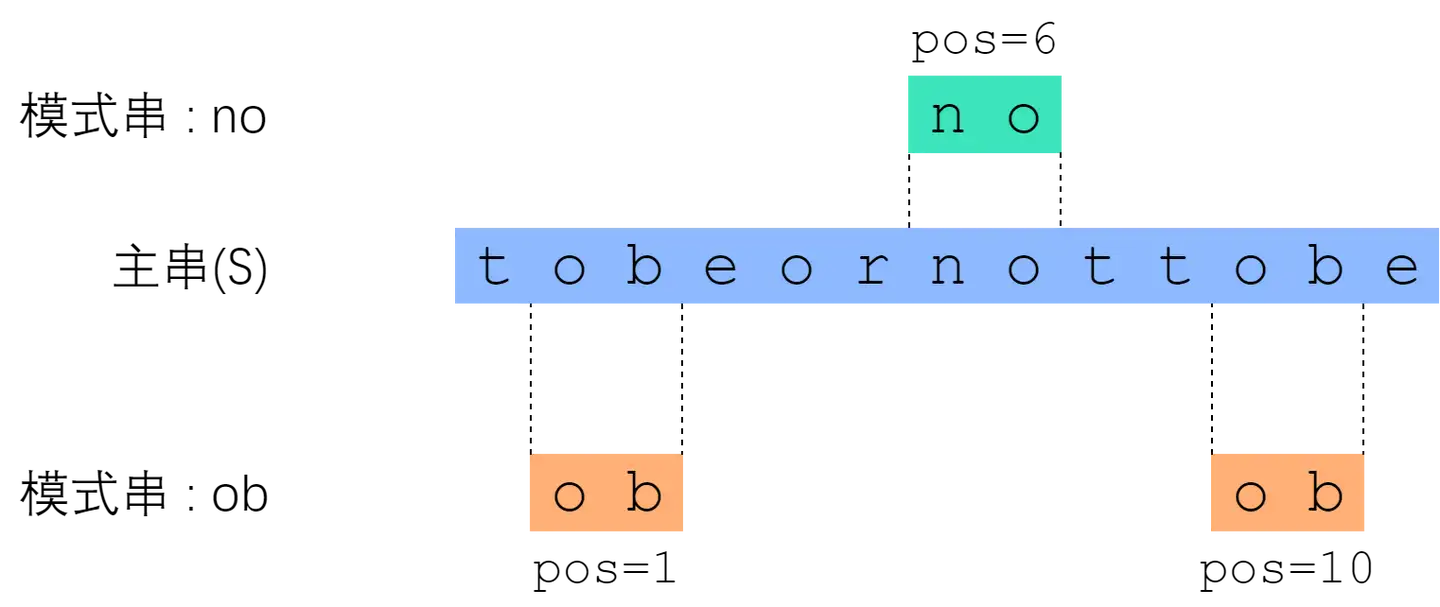

主串是莎翁那句著名的 “to be or not to be”，这里删去了空格。“no” 这个模式串的匹配结果是“出现了一次，从S[6]开始”；“ob”这个模式串的匹配结果是“出现了两次，分别从s[1]、s[10]开始”。按惯例，主串和模式串都以0开始编号。　

字符串匹配是一个非常频繁的任务。例如，今有一份名单，你急切地想知道自己在不在名单上；又如，假设你拿到了一份文献，你希望快速地找到某个关键字（keyword）所在的章节……凡此种种，不胜枚举。

我们从最朴素的brute-force算法开始

---



### Brute-force

我们一个一个移动模式串，挨个匹配是否相等

下面是一个模拟Brute-Force算法，对主串"AAAAABC"和模式串"AAAB"做匹配：

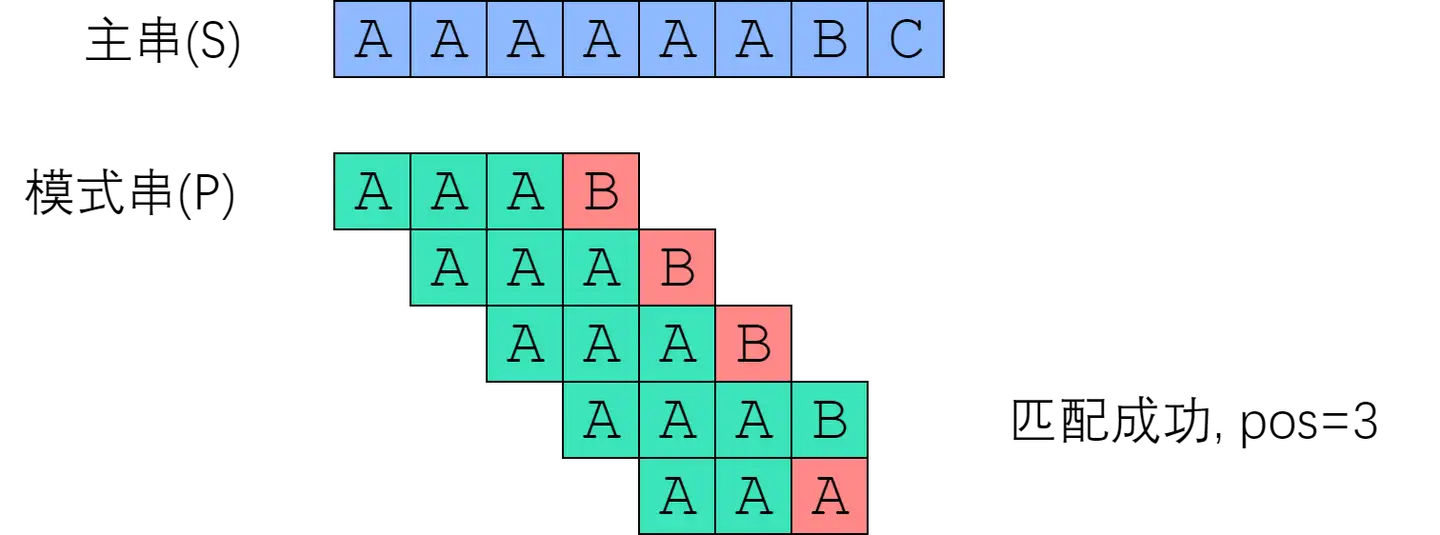

我们可以给出一个python实现的算法

```python
    def bruteForece(S,P):
        for i in range(len(S)-len(P)+1):
            if S[i : i + len(P)] = P:
                print(f'pos = {i}')
```

我们成功实现了Brute-Force算法。我们来进行时间复杂度讨论，我们设$n = |S|$和$m = |P|$，m和n分别为S和P串的长度。

考虑“字符串比较”这个小任务的复杂度。最坏情况发生在：两个字符串唯一的差别在最后一个字符。这种情况下，字符串比较必须走完整个字符串，才能给出结果，因此复杂度是 $O(len)$ 的。　

由此，不难想到 Brute-Force 算法所面对的最坏情况：主串形如“AAAAAAAAAAA...B”，而模式串形如“AAAAA...B”。每次字符串比较都需要付出 |P| 次字符比较的代价，总共需要比较 |S| - |P| + 1次，因此总时间复杂度是  $O(|P|⋅(|S|−|P|+1)) $. 考虑到主串一般比模式串长很多，故 Brute-Force 的复杂度是 $O(|P|⋅|S|)$ ，也就是 $O(nm)$的。这太慢了！

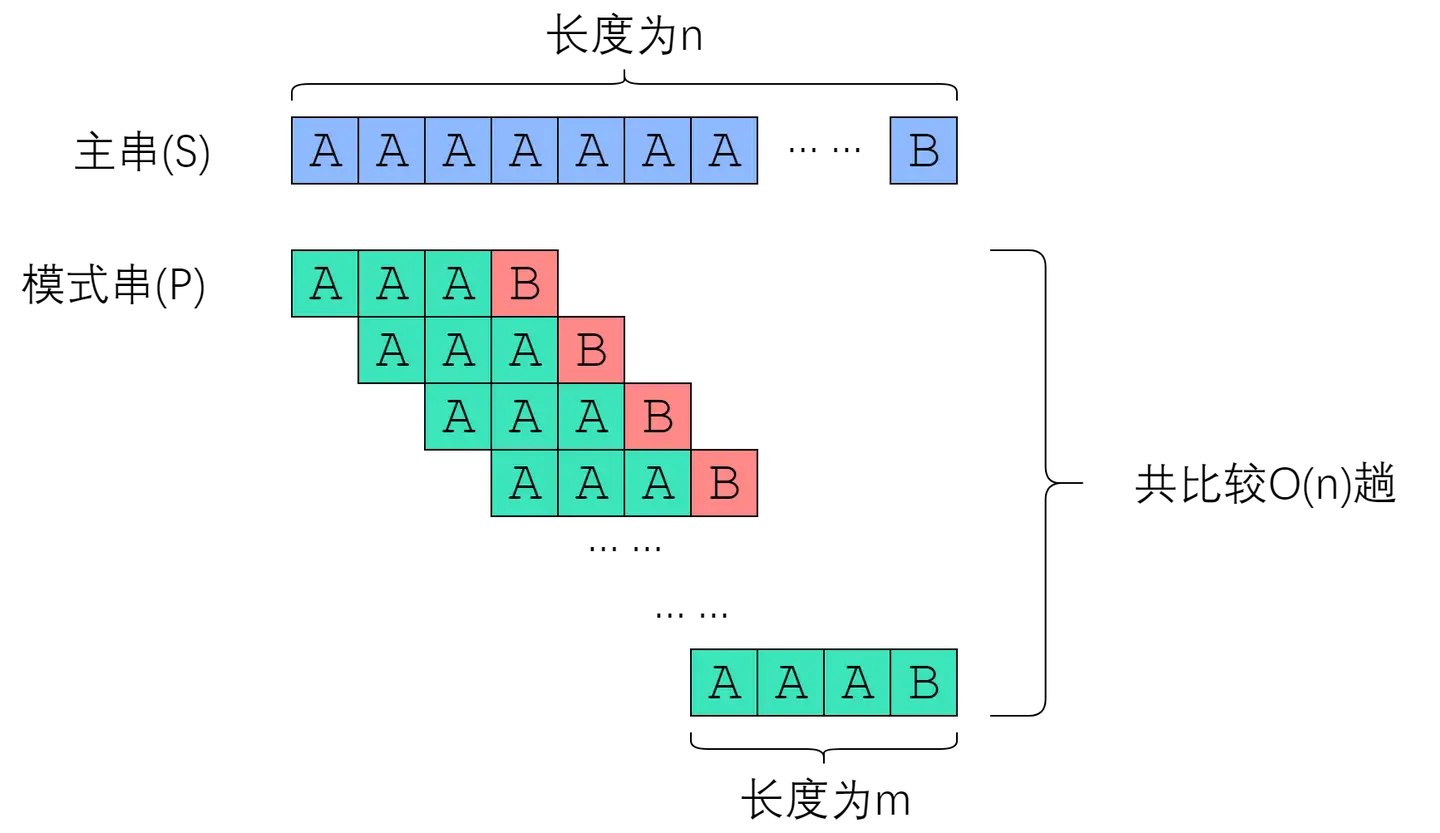


#### 改进思路

我们很难降低字符串比较的复杂度，因此我们选择降低比较的**趟数**。如果比较的趟数可以降低到足够低，那么总的复杂度也会下降很多。**尽可能利用残余的信息，是KMP算法的思想所在。***

在Brute-Force算法中，如果从S[i]开始的那趟比较失败了，算法会尝试从S[i+1]开始比较。我们应当注意，一次失败的匹配，会给我们提供宝贵的信息--如果S[i:i+len(P)]与P的匹配是在第r个位置失败的，那么从S[i]开始的(r-1)个连续字符，一定与P的前(r-1)个字符一模一样

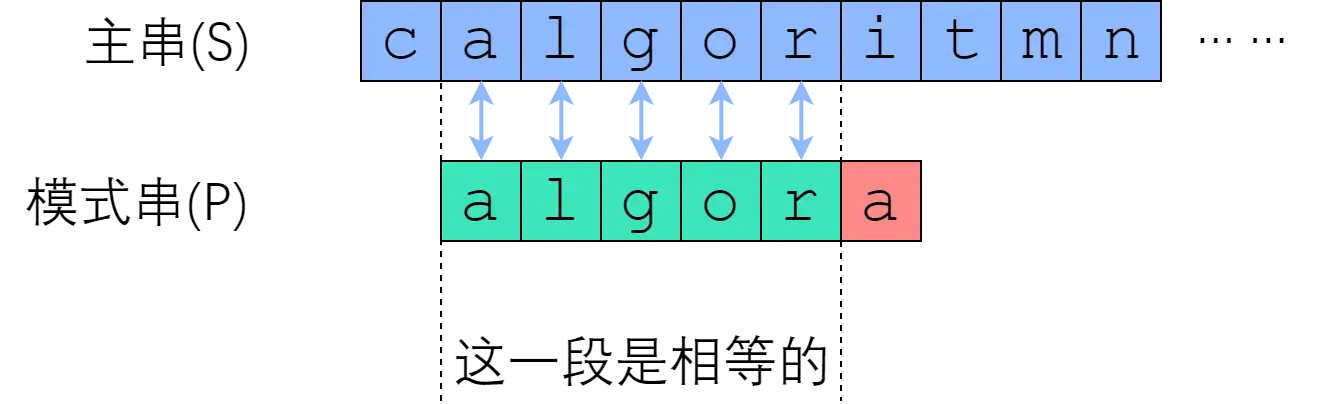

需要实现的任务是“字符串匹配”，而每一次失败都会给我们换来一些信息——能告诉我们，主串的某一个子串等于模式串的某一个前缀。但是这又有什么用呢？

#### 跳过不可能成功的字符串比较

有些字符串比较是有可能成功；有些则毫无可能。我们刚刚提到过，我们刚刚提到过，优化 Brute-Force 的路线是“尽量减少比较的趟数”，而如果我们跳过那些**绝不可能成功**的字符串比较，则可以希望复杂度降低到能接受的范围。

我们来看例子：
- 模式串$ P = "abcabd"$
- 和主串从S[0]开始匹配时，在P[5]处匹配失败。

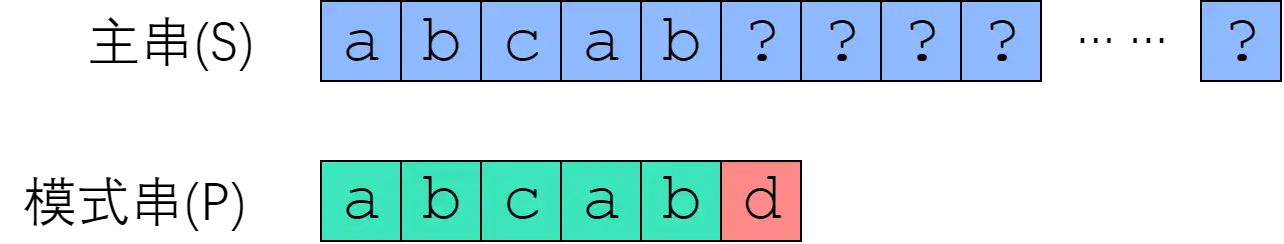

既然在P[5]失败，那么说明S[0:5]等于P[0:5]，即"abcabd"。现在我们来考虑：从S[1]、S[2]、S[3]开始的匹配是否有可能成功。

从S[1]开始肯定没办法成功，因为$S[1] = P[1] = 'b'$，和 $P[0]$ 并不相等。从S[2]开始也是没戏，因为 S[2] = P[2] = 'c'，并不等于P[0]. 但是从 S[3] 开始是有可能成功的——至少按照已知的信息，我们推不出矛盾。

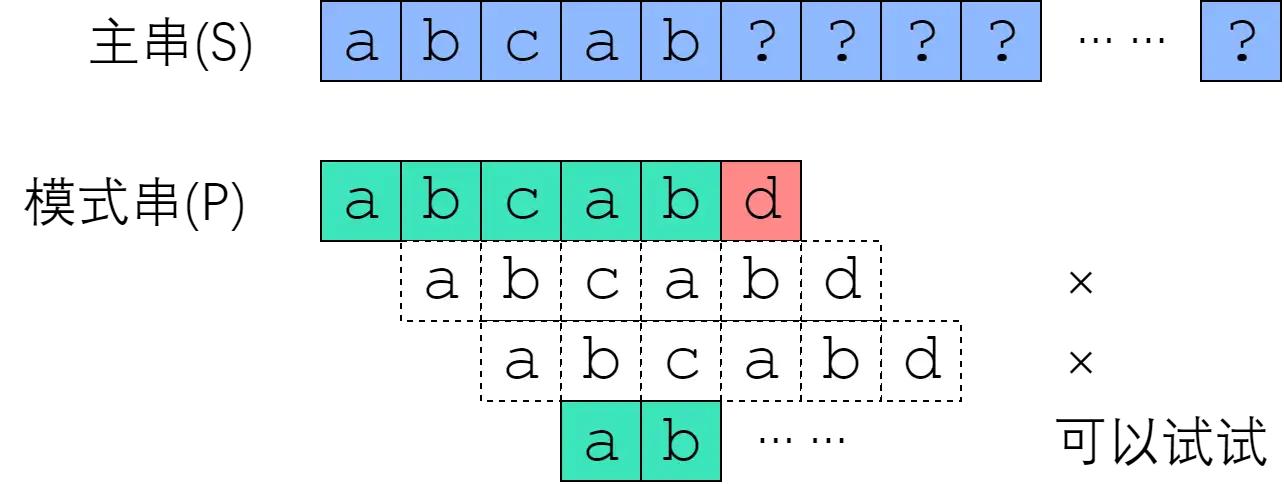

带着"跳过不可能成功的尝试"的思想，我们来看next数组。

#### next数组

next数组是对于模式串而言的。P 的 next 数组定义为：next[i] 表示 P[0] ~ P[i] 这一个子串，使得$前k个字符恰等于后k个字符$的最大的k. 特别地，k不能取i+1（因为这个子串一共才 i+1 个字符，自己肯定与自己相等，就没有意义了）。

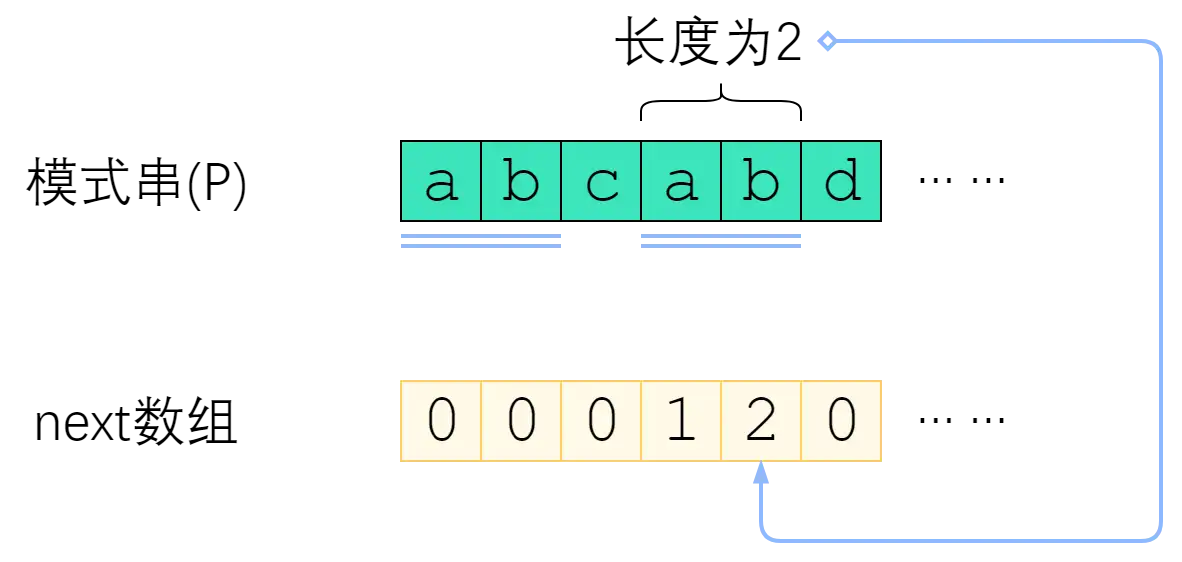

如上图所示，P="abcabd"时，next[4]=2，这是因为P[0] ~ P[4] 这个子串是"abcab"，前两个字符与后两个字符相等，因此next[4]取2. 而next[5]=0，是因为"abcabd"找不到前缀与后缀相同，因此只能取0.

如果把模式串视为一把标尺，在主串上移动，那么 Brute-Force 就是每次失配之后只右移一位；改进算法则是**每次失配之后，移很多位**，跳过那些不可能匹配成功的位置。但是该如何确定要移多少位呢？

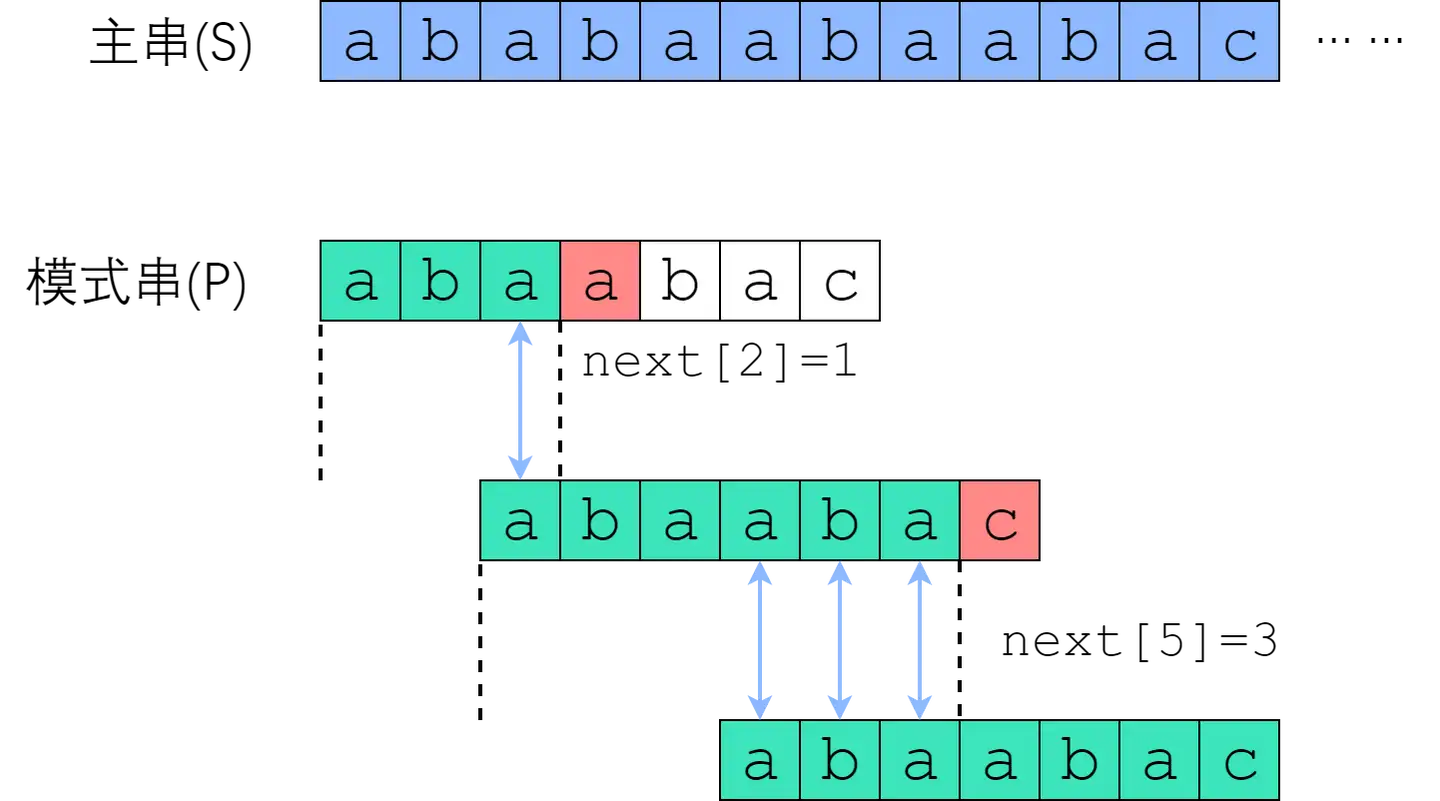




在 S[0] 尝试匹配，失配于 S[3] <=> P[3] 之后，我们直接把模式串往右移了两位，让 S[3] 对准 P[1]. 接着继续匹配，失配于 S[8] <=> P[6], 接下来我们把 P 往右平移了三位，把 S[8] 对准 P[3]. 此后继续匹配直到成功。　　

我们应该如何移动这把标尺？很明显，如图中蓝色箭头所示，旧的后缀要与新的前缀一致（如果不一致，那就肯定没法匹配上了）！　　

回忆next数组的性质：P[0] 到 P[i] 这一段子串中，前next[i]个字符与后next[i]个字符一模一样。既然如此，如果失配在 P[r], 那么P[0]~P[r-1]这一段里面，前next[r-1]个字符恰好和后next[r-1]个字符相等——也就是说，我们可以拿长度为 next[r-1] 的那一段前缀，来顶替当前后缀的位置，让匹配继续下去！　　

可以验证一下上面的匹配例子：**P[3]失配后，把P[next[3-1]]也就是P[1]对准了主串刚刚失配的那一位；P[6]失配后，把P[next[6-1]]也就是P[3]对准了主串刚刚失配的那一位。**

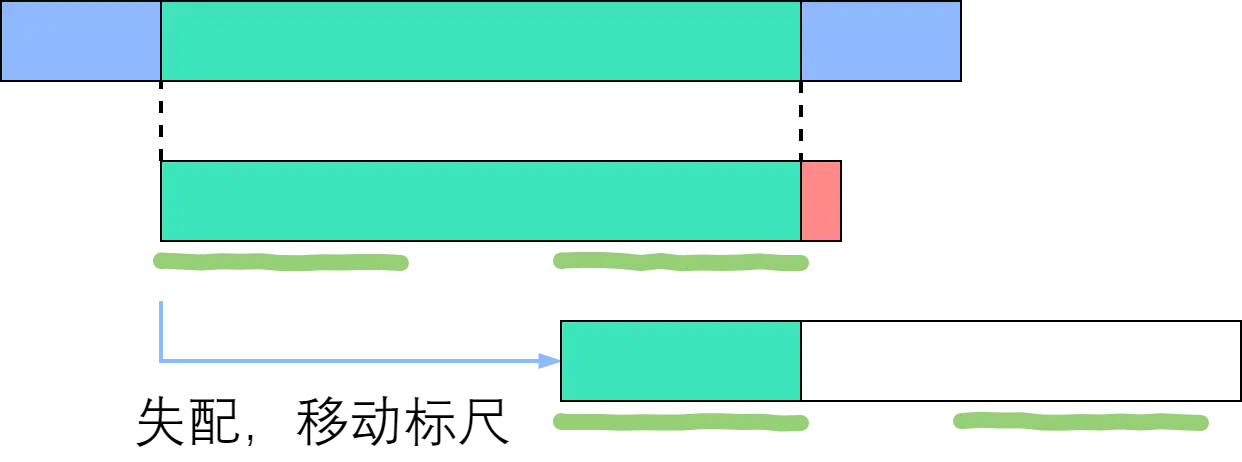

如上图所示，绿色部分是成功匹配，失配于红色部分。深绿色手绘线条标出了相等的前缀和后缀，其长度为next[右端]. 由于手绘线条部分的字符是一样的，所以直接把前面那条移到后面那条的位置。因此说，next数组为我们如何移动标尺提供了依据。接下来，我们实现这个优化的算法。

---


#### 利用next数组进行匹配

显然我们的优化方法分为两个部分：1.建立next数组，2.利用next数组进行匹配

首先是建立next数组，下面是最朴素的方法，之后再优化：

```python
def getNxt(p):
    n = len(p)
    nxt = [0]*n

    for i in range(n):
        for k in range(i,0,-1):
            if p[:k] == p[i-k+1:i+1]:
                nxt[i] = k
                break
    return nxt
```

其时间复杂度显然为$O(n^2)$,在最坏的情况下为$O(n^3)$


In [25]:
p = "abaabac"
print(getNxt("abaabac"))  # [0, 0, 1, 1, 2, 3, 0]

[0, 0, 1, 1, 2, 3, 0]


接下来我们用next数组来加速字符串匹配：
```python

def search(s,p):
    n = len(s) #主串长度
    m = len(p) #模式串长度

    nxt = getNxt(p)

    i = 0 #主串指针
    j = 0 #模式串指针

    while i <n :
        if s[i] == p [i]:#当前字符匹配
            i += 1
            j += 1
            if j == m: #模式串匹配完成
                return i - j#找到匹配，返回起始位置
                #  j =nxt[j-1]
        else: #不匹配
            if j > 0 : #j不是0才可以回退
                j = nxt[j-1] #模式指针跳回到nxt[j - 1]
            
            else: i +=1
    return -1 #没找到

```

显然其时间复杂度为$O(n+m)$

In [ ]:
s = "ababaabaabac"
p = "abaabac"

# 假设 getNxt(p) 返回 [0, 0, 1, 1, 2, 3, 0]

result = search(s, p)
print(result)  # 应该输出 5

5


#### 快速求next数组

快速构建next数组是kmp算法的精髓所在，核心思想是"P自己与自己做匹配“.

我们不一个一个枚举所有可能的长度，而是**边计算边利用已经算好的next值**来加速，就像匹配过程一样(时间复杂度$O(m)$，m为模式串长度)

```python
def get_next(pattern):
    m = len(pattern)
    nxt = [0] * m
    j = 0  #j为前缀末尾
    
    for i in range(1, m):  # i 从1开始，i为后缀末尾
        while j > 0 and pattern[i] != pattern[j]:
            j = nxt[j - 1]  # 不断回退 j，直到能匹配或 j=0
        
        if pattern[i] == pattern[j]:
            j += 1
        
        nxt[i] = j
    
    return nxt
```

#### 用"abaabac"演示

| i | pattern[i] | j (操作前) | 匹配状态 & 决策逻辑 | nxt[i] (结果) |
| :--- | :--- | :--- | :--- | :--- |
| **1** | b | 0 | 不等：j = 0, 不满足 s[i]==s[j] | **0** |
| **2** | a | 0 | 等于：p[0] == p[2] -> j = 1 | **1** |
| **3** | a | 1 | 不等：a != b -> while回跳: j = nxt[0]=0; 现在 j=0, a == a -> j = 1 | **1** |
| **4** | b | 1 | 等于：b == b -> j = 2 | **2** |
| **5** | a | 2 | 等于：a == a -> j = 3 | **3** |
| **6** | c | 3 | 不等：c != a -> while回跳: j = nxt[2]=1; <br> 仍不等: c != b -> j = nxt[0]=0; <br> 仍不等: j=0, c != a | **0** |
